# Quantum GANs: The Patch Method

## Module Imports

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 302
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data

In [3]:
color_channel = 1
image_size = 256 

In [4]:
import os
from torchvision.io import read_image, ImageReadMode

class AnimeDatset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.image = torch.cat([
            read_image(f'{dir_path}/{file_name}', ImageReadMode.GRAY)
                .view(1, color_channel, image_size, image_size)
            for file_name in os.listdir(dir_path)
        ]).float() / 255

        self.length = len(self.image)
        self.transform = transform
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = self.image[idx, :, :, :]

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [5]:
batch_size = 1

dataset = AnimeDatset(dir_path="anime256")

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

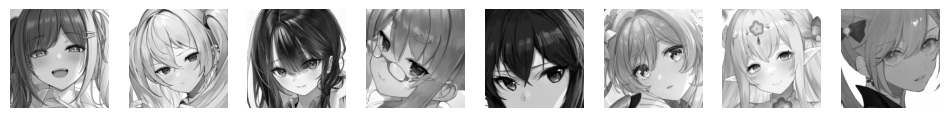

In [6]:
plt.figure(figsize=(12,10))

for i, idx in enumerate(random.sample(range(len(dataset)), 8)):
    image = dataset[idx][0].permute(1, 2, 0)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), 'gray')

plt.show()

## Implementing the Discriminator

In [ ]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        nc = color_channel
        ndf = 1

        self.conv1 = nn.Conv2d(
            in_channels=nc,
            out_channels=1, 
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
        )
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(
            in_channels=nc,
            out_channels=1, 
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
        )
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(
            in_channels=nc,
            out_channels=1, 
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
        )
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(
            in_channels=nc,
            out_channels=1, 
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
        )

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.sigmoid(x)
        return x

## Implementing the Generator

In [ ]:
# Quantum simulator
dev_9bit = qml.device("lightning.gpu", wires=9, batch_obs=True)
# dev_9bit = qml.device("default.qubit", wires=9)

# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [ ]:
@qml.qnode(dev_9bit, interface="torch", diff_method="parameter-shift")
def quantum_circuit(inputs, weight):
    q_depth, n_qubits = weight.shape

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weight[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

In [ ]:
class QuantumLinear(nn.Module):
    def __init__(self, in_size, n_ancilla=0, q_depth=5, q_delta=1):
        super().__init__()
        
        self.patch_size = 2 ** ((in_size - n_ancilla) // 2)
        self.partial_size = 2 ** ((in_size - n_ancilla))

        weight_shape = {'weight': (q_depth, in_size)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shape)
    
    def forward(self, x):        
        batch = torch.cat([
            self.qlayer(elem.contiguous().view(-1))[:self.partial_size]
                .view(1, 1, self.patch_size, self.patch_size)
            for elem in x
        ]).to(device)
        return batch

In [ ]:
class QuantumParallelLinear(nn.Module):
    def __init__(self, in_size, filter_size=3, padding=1, n_ancilla=1, q_depth=5, q_delta=1):
        super().__init__()

        self.in_size = in_size
        self.filter_size = filter_size
        self.n_qubits = filter_size ** 2

        self.zeropad = nn.ZeroPad2d(padding)
        self.linear = nn.ModuleList([
            QuantumLinear(self.n_qubits, n_ancilla, q_depth)
            for _ in range(in_size * in_size)
        ])
              

    def forward(self, x):
        x = self.zeropad(x)

        patch = torch.cat([
            torch.cat([
                self.linear[i+j*self.in_size](x[:, :, i:i+self.filter_size, j:j+self.filter_size])
                for i in range(self.in_size)
            ], dim=-2)
            for j in range(self.in_size)
        ], dim=-1)
        
        return patch

In [ ]:
class QuantumTransposedConv(nn.Module):
    def __init__(self, in_size, filter_size=3, padding=1, n_ancilla=1, q_depth=5, q_delta=1):
        super().__init__()

        self.in_size = in_size
        self.filter_size = filter_size
        self.n_qubits = filter_size ** 2

        self.layers = nn.ModuleDict({
            'zeropad': nn.ZeroPad2d(padding),
            'linear': QuantumLinear(self.n_qubits, n_ancilla, q_depth)
        })
        

    def forward(self, x):
        x = self.layers['zeropad'](x)

        patch = torch.cat([
            torch.cat([
                self.layers['linear'](x[:, :, i:i+self.filter_size, j:j+self.filter_size])
                for i in range(self.in_size)
            ], dim=-2)
            for j in range(self.in_size)
        ], dim=-1)
        
        return patch / patch.max()

In [ ]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        super().__init__()
        
        self.layers = nn.ModuleDict({
            'linear': QuantumLinear(8, q_depth=2),
            'tpconv': QuantumParallelLinear(16, q_depth=2)
        })

    def forward(self, x):
        x = self.layers['linear'](x)
        x = self.layers['tpconv'](x)
        return x

## Training

In [ ]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500   # Number of training iterations

latent_size = 8

In [ ]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator().to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, latent_size, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.view(-1, color_channel, 256, 256).to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, latent_size, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.20f}')
        if counter % 10 == 0:
            # Save images every 10 iterations
            test_image = generator(fixed_noise).view(color_channel, image_size, image_size).permute(1, 2, 0).cpu().detach()
            results.append(test_image)
            plt.imshow(test_image)
            plt.axis('off')
            plt.show()
            
            
        if counter == num_iter:
            break
    if counter == num_iter:
        break